In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [2]:
premium_data= pd.read_excel('premiums.xlsx')
premium_data.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [3]:
premium_data.shape

(50000, 13)

In [4]:
premium_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    50000 non-null  int64 
 1   Gender                 50000 non-null  object
 2   Region                 50000 non-null  object
 3   Marital_status         50000 non-null  object
 4   Number Of Dependants   50000 non-null  int64 
 5   BMI_Category           50000 non-null  object
 6   Smoking_Status         49989 non-null  object
 7   Employment_Status      49998 non-null  object
 8   Income_Level           49987 non-null  object
 9   Income_Lakhs           50000 non-null  int64 
 10  Medical History        50000 non-null  object
 11  Insurance_Plan         50000 non-null  object
 12  Annual_Premium_Amount  50000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.0+ MB


DATA VALIDATION

1. Trim the whitespaces

2. Check for duplicates
   
3. Check for missing values

4. Check for outliers


In [5]:
all_columns= list(premium_data.columns)
all_columns

['Age',
 'Gender',
 'Region',
 'Marital_status',
 'Number Of Dependants',
 'BMI_Category',
 'Smoking_Status',
 'Employment_Status',
 'Income_Level',
 'Income_Lakhs',
 'Medical History',
 'Insurance_Plan',
 'Annual_Premium_Amount']

In [7]:
#change the column names to snake_case
premium_data.columns= premium_data.columns.str.replace(" ","_").str.lower()
all_columns= list(premium_data.columns)
all_columns

['age',
 'gender',
 'region',
 'marital_status',
 'number_of_dependants',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'income_lakhs',
 'medical_history',
 'insurance_plan',
 'annual_premium_amount']

In [8]:
premium_data['gender'].dtype == 'object'

True

In [9]:
#apply map is a function which applies to every cell in the data, however it is not efficient or takes time for large datasets
#premium_data= premium_data.applymap(lambda x: x.strip if isinstance(x, str) else x)
#The below code removes white spaces

for col in all_columns:
    if premium_data[col].dtype == object:
        premium_data[col]= premium_data[col].str.strip()
    


check for duplicates

In [10]:
duplicates = premium_data[premium_data.duplicated()]
duplicates

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


There are no duplicates, now let us check for missing values

In [11]:
premium_data.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

As there are only less duplicates we can drop them, or else we can fill them with one of the following methods

1. Mean Imputation
2. Median Imputation
3. Frequent Category Imputation
4. Random Imputation
5. Regression Imputation
6. Constant Value Immputation
7. Last/ Next non value imputation

In [12]:
#You can use this function to randomly, however i am dropping the rows as they are very low
def random_imputation( dataset, col):
    total_missing_values= dataset[col].isna().sum()
    #generate a sample of above length 
    sample= dataset[dataset[col].notna()].sample(total_missing_values, replace= True, random_state= 30)
    missing_indices= dataset[dataset[col].isna()].index
    dataset.loc[missing_indices, col]= sample.values
    return dataset

In [13]:
premium_data.dropna(inplace= True)

In [14]:
premium_data.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

Check for outliers

In [15]:
numerical_columns = list(premium_data.select_dtypes(include='int64').columns)
numerical_columns

['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

In [16]:
categorical_columns = list(premium_data.select_dtypes(include='object').columns)
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

NUMERICAL COLUMNS DISTRIBUTION

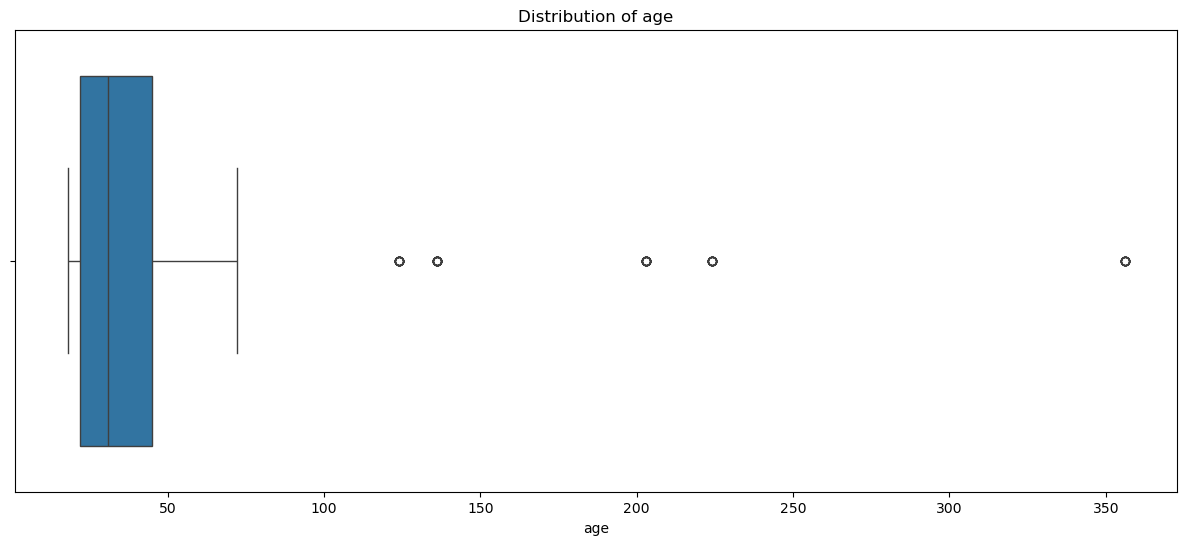

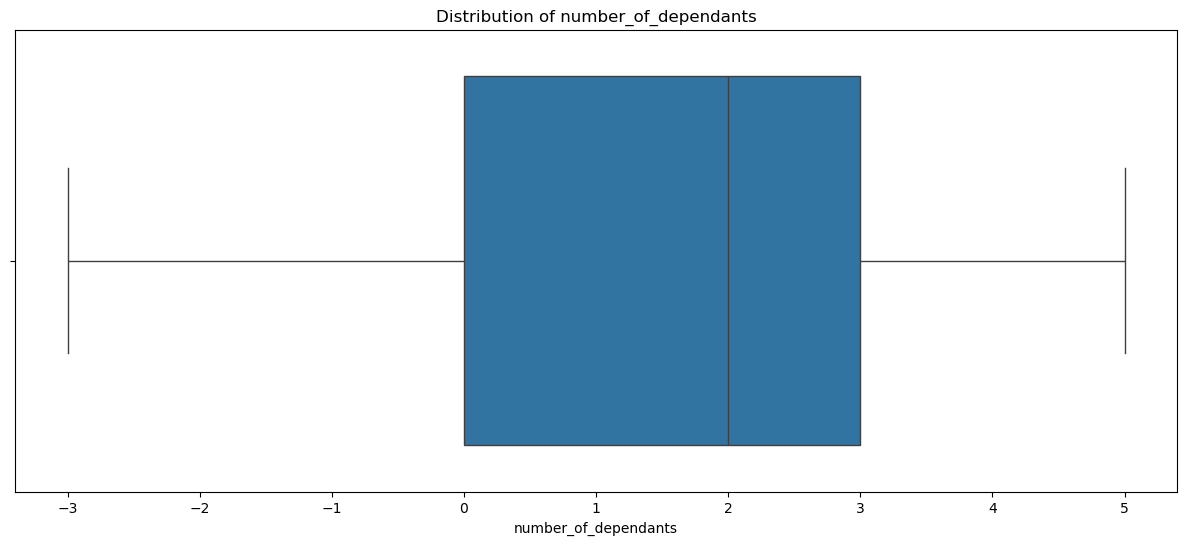

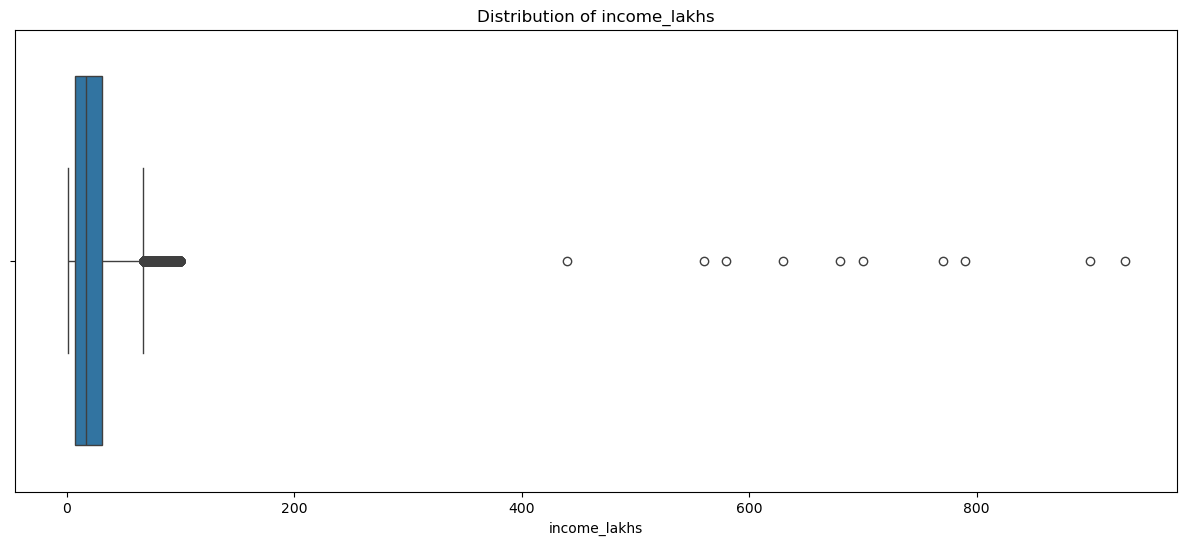

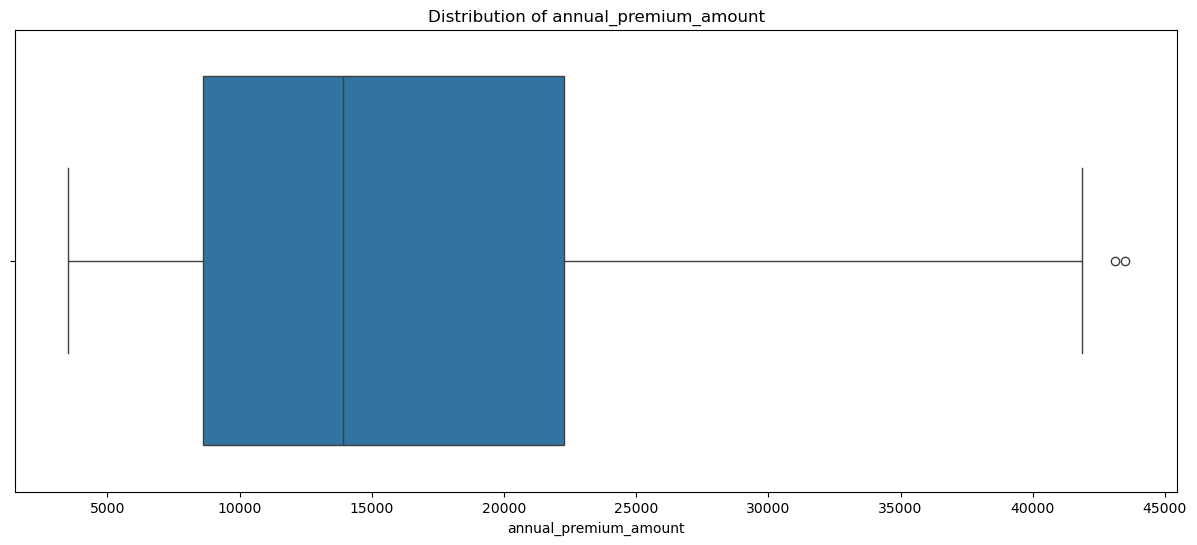

In [17]:
for column in numerical_columns:
    plt.figure(figsize=(15,6))
    sns.boxplot(x=column,data=premium_data)
    plt.title(f'Distribution of {column}')
    

We can take decision on other outliers, before that if we see dependants there are negative which is not a valid one

In [18]:
premium_data[premium_data['number_of_dependants']<0]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
402,23,Female,Southwest,Unmarried,-3,Underweight,No Smoking,Freelancer,10L - 25L,18,No Disease,Silver,9309
2245,18,Male,Southwest,Unmarried,-3,Overweight,No Smoking,Freelancer,25L - 40L,28,No Disease,Silver,8095
2323,19,Male,Northwest,Unmarried,-3,Underweight,No Smoking,Freelancer,25L - 40L,40,No Disease,Bronze,4641
2986,34,Female,Southeast,Married,-1,Underweight,Regular,Self-Employed,25L - 40L,35,High blood pressure & Heart disease,Silver,22995
3756,41,Male,Southwest,Married,-1,Obesity,Regular,Salaried,10L - 25L,21,Diabetes,Silver,22766
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48062,23,Male,Northwest,Unmarried,-1,Normal,No Smoking,Freelancer,> 40L,54,No Disease,Gold,13601
48086,36,Female,Southwest,Married,-1,Obesity,Occasional,Salaried,<10L,3,Diabetes,Bronze,14422
49256,60,Female,Southwest,Married,-1,Normal,No Smoking,Self-Employed,10L - 25L,21,Thyroid,Bronze,10141
49270,34,Male,Southeast,Married,-1,Obesity,No Smoking,Self-Employed,10L - 25L,17,Diabetes & Thyroid,Silver,21816


In [19]:
#let's make them positive values.
premium_data['number_of_dependants']= premium_data['number_of_dependants'].abs()

In [20]:
#now check
premium_data[premium_data['number_of_dependants']<0]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


In [21]:
#Now inspect the age , it has more than 100. so filter out the records less than 100 only
premium_data_filtered= premium_data[premium_data['age']<=100]
premium_data_filtered.shape

(49918, 13)

Outlier Treatment for others using IQR

<Axes: xlabel='number_of_dependants'>

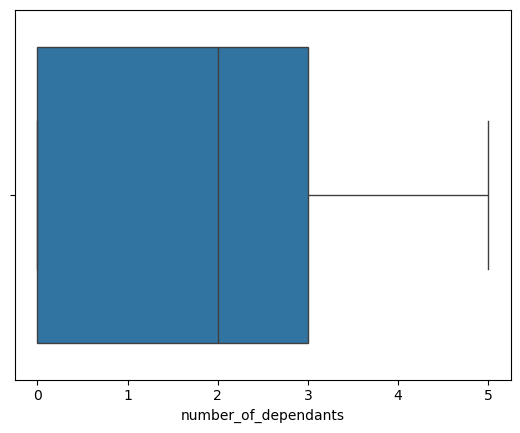

In [22]:
sns.boxplot(x= premium_data_filtered['number_of_dependants'])

In [60]:
def outlier_removal(dataset, col):
    Q1, Q3 = dataset[col].quantile([0.25,0.75])
    IQR= Q3- Q1
    upper_fence= Q3+ 1.5* IQR
    lower_fence= Q3- 1.5*IQR
    return lower_fence,upper_fence
    
    

In [41]:
higher_fence, lower_fence = outlier_removal(premium_data_filtered, 'income_lakhs')
print(lower_fence, higher_fence)


-5.0 67.0


In [52]:
#before dropping check how many rows are outliers
premium_data_filtered[(premium_data_filtered['income_lakhs'] <= lower_fence) | (premium_data_filtered['income_lakhs'] >= higher_fence)].shape

(3660, 13)

As they are 3660 records, removing them is not a viable solution, so after discussing with business team plan to drop above 99 percentile

In [55]:
premium_data_filtered_1=premium_data_filtered[premium_data_filtered['income_lakhs']<=premium_data_filtered['income_lakhs'].quantile(0.99)]

In [56]:
premium_data_filtered_1.shape

(49472, 13)

In [61]:
lf,hf=outlier_removal(premium_data_filtered_1,"annual_premium_amount")
print(lf,hf)

1765.5 42694.5


In [63]:
#before dropping check how many rows are outliers
premium_data_filtered[(premium_data_filtered['annual_premium_amount'] < lf) | (premium_data_filtered['annual_premium_amount'] > hf)].shape

(2, 13)

In [64]:
premium_data_filtered_2= premium_data_filtered[(premium_data_filtered['annual_premium_amount'] >= lf) | (premium_data_filtered['annual_premium_amount'] <= hf)]

In [65]:
premium_data_filtered_2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


CATEGORICAL VARIABLES 

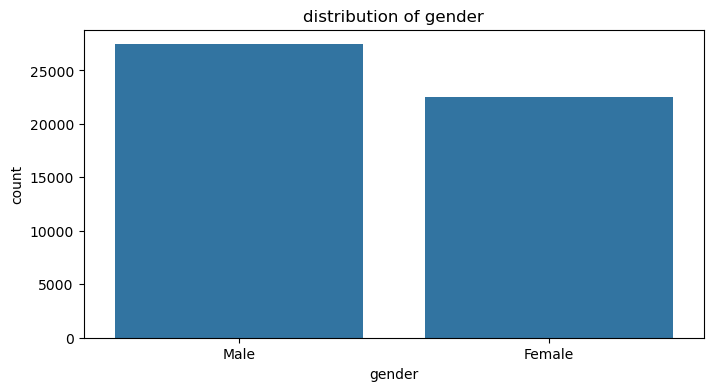

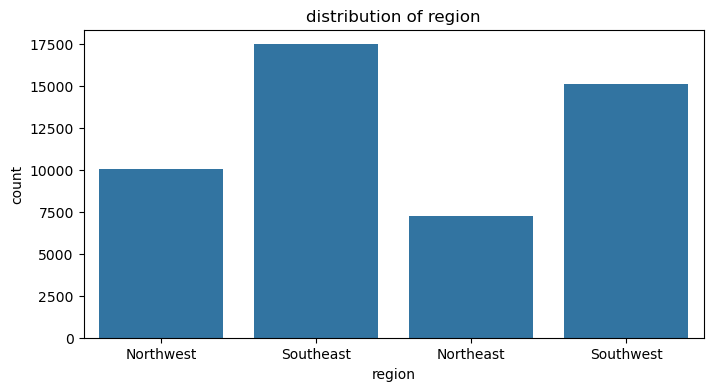

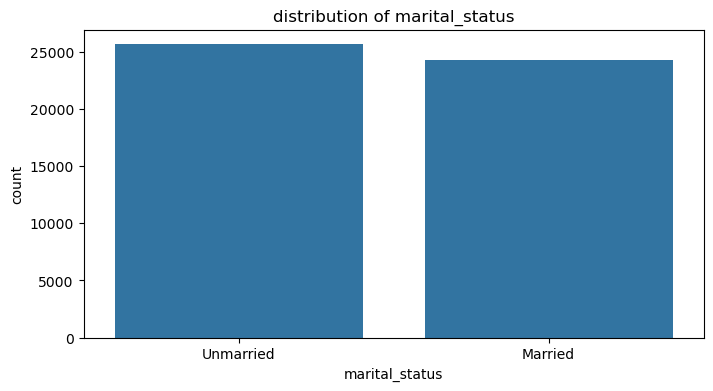

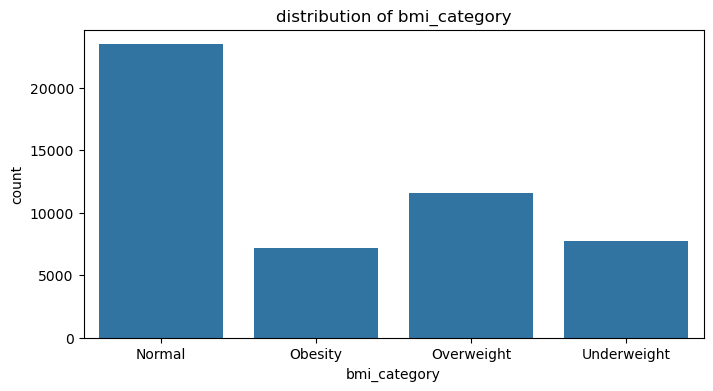

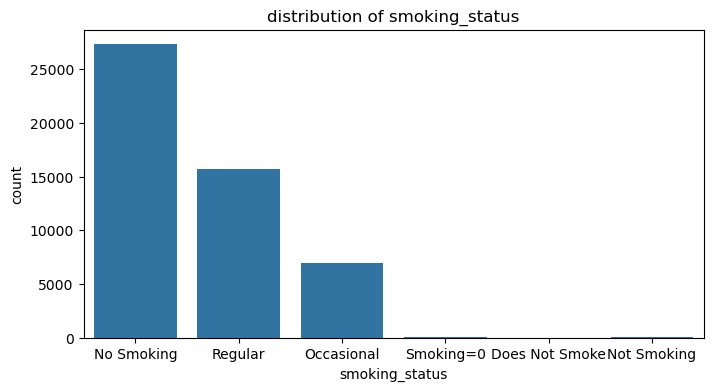

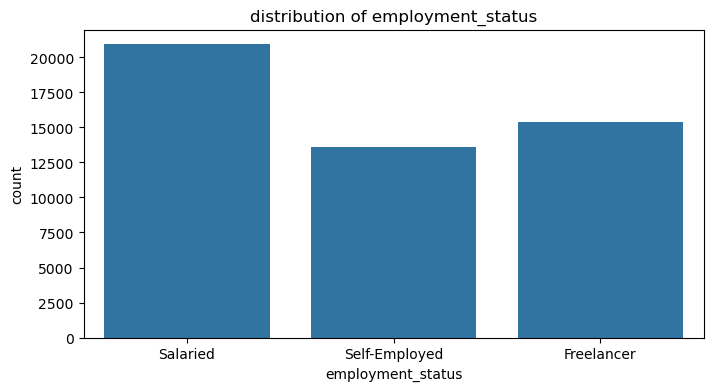

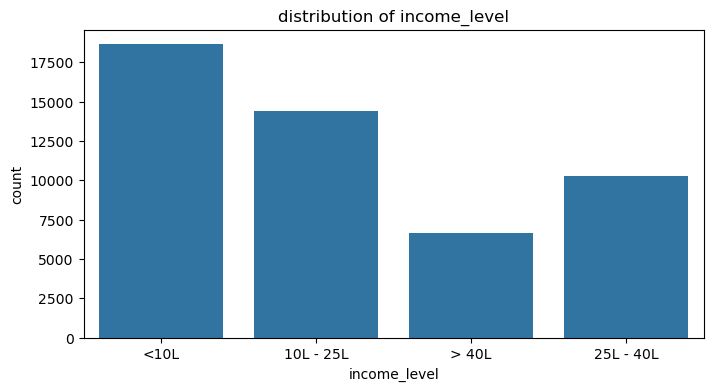

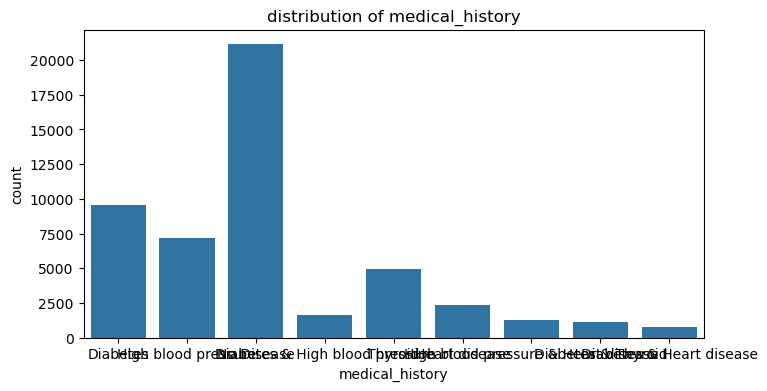

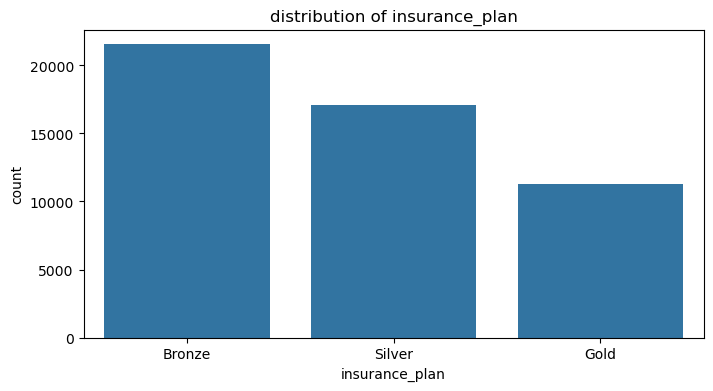

In [71]:
for col in categorical_columns:
    plt.figure(figsize=(8,4))
    plt.title(f'distribution of {col}')
    sns.countplot(x= premium_data_filtered_2[col])
    

If you see in above smoking has some same meaning entries with different words

In [72]:
premium_data_filtered_2['smoking_status'].value_counts()

smoking_status
No Smoking        27328
Regular           15665
Occasional         6903
Smoking=0             8
Not Smoking           8
Does Not Smoke        6
Name: count, dtype: int64

In [73]:
premium_data_filtered_2['smoking_status'].replace({'Smoking=0':'No Smoking',
                                                   'Not Smoking':'No Smoking',
                                                   'Does Not Smoke': 'No Smoking'}, inplace=True
                                                                                             
                                                                                             
                                                                                        )

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_1106/1788659773.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  premium_data_filtered_2['smoking_status'].replace({'Smoking=0':'No Smoking',


In [74]:
premium_data_filtered_2['smoking_status'].value_counts()

smoking_status
No Smoking    27350
Regular       15665
Occasional     6903
Name: count, dtype: int64

BI VARIATE ANALYSIS

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_1106/1487796341.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)


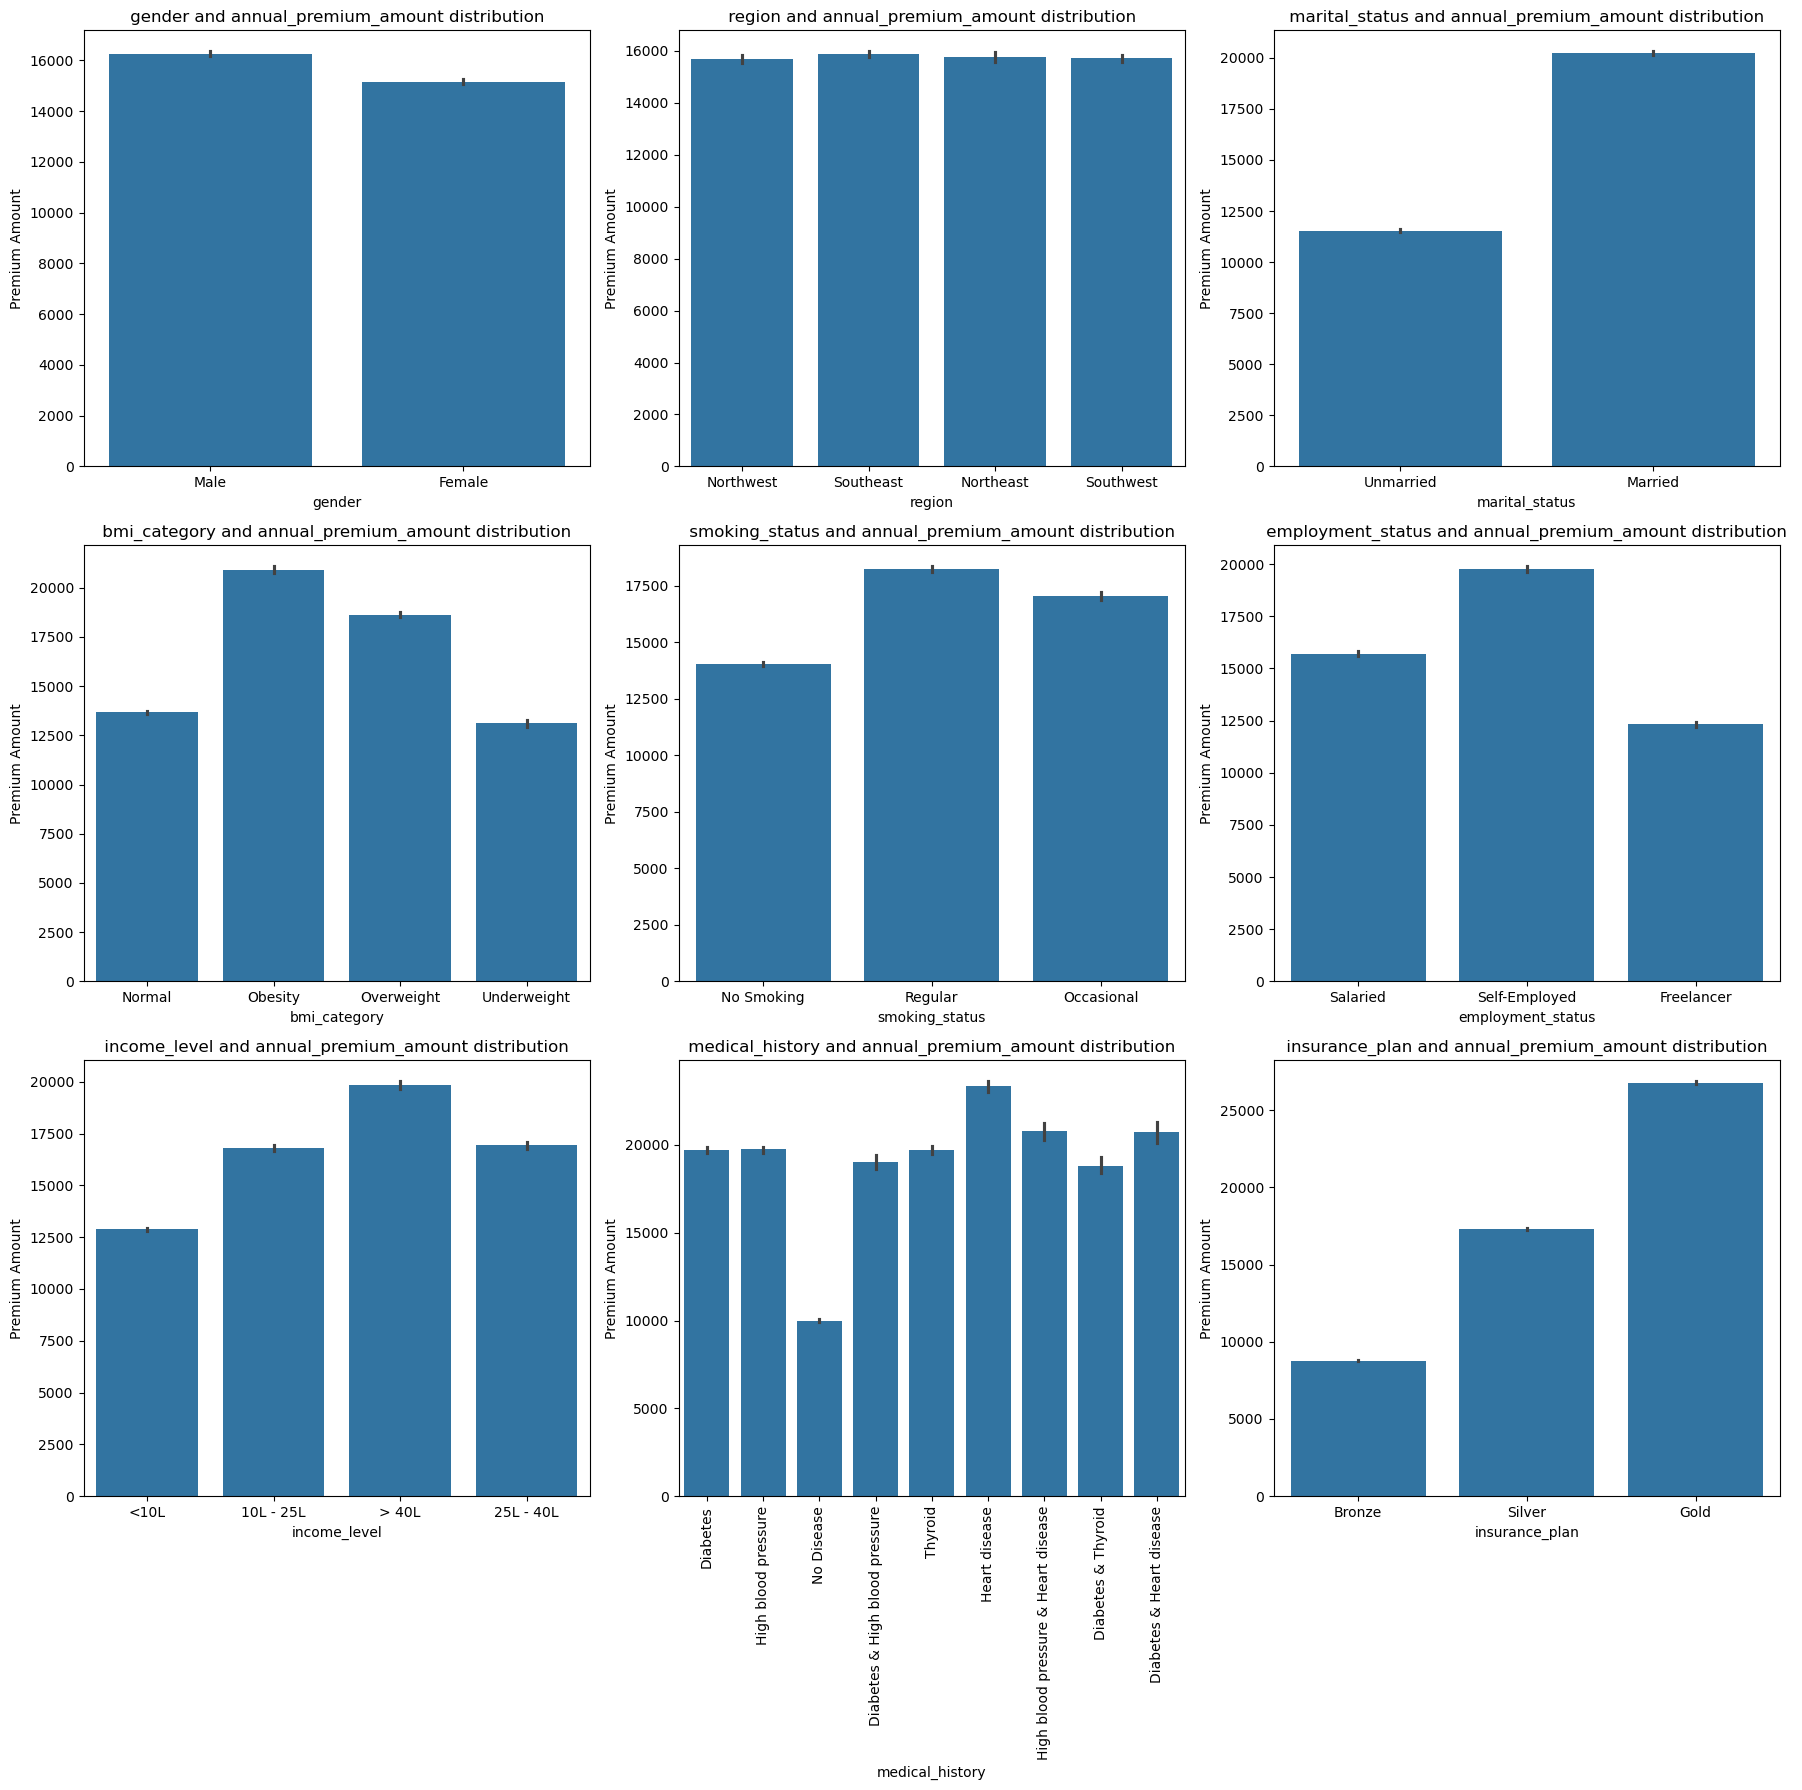

In [83]:
fig, axes= plt.subplots(3,3,figsize=(18,18))
axes= axes.flatten()

for ax, column in zip(axes, categorical_columns):
    sns.barplot(x= column, y= 'annual_premium_amount', data= premium_data_filtered_2, ax= ax)
    ax.set_title(f' {column} and annual_premium_amount distribution ')
    ax.set_ylabel('Premium Amount')
    if column == "medical_history":
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)
    ax.set_xlabel(f'{column}')

plt.tight_layout()
plt.show()
    
#axes

Everything is good , now we should encode the categorical variables. There are various methods to encode, some of them are

1. Label Encoding ( for ordinal )
2. Target Encoding
3. One hot encoding
4. Binary Encoding
5. Frequency Encoding






| Algorithm             | Be Careful With?      | Recommended Encoding          |
| --------------------- | --------------------- | ----------------------------- |
| Linear/Logistic Reg.  | Yes                   | One-Hot, Ordinal (if ordered) |
| SVM                   | Yes                   | One-Hot, Binary               |
| KNN                   | Yes                   | One-Hot, Binary               |
| Neural Networks (MLP) | Yes                   | One-Hot, Embeddings           |
| Decision Tree         | Not Really            | Label, One-Hot, Target        |
| Random Forest         | Not Really            | Label, One-Hot, Target        |
| XGBoost/LightGBM      | Not Really            | Label, Target, One-Hot        |
| CatBoost              | No (handles natively) | Raw categorical OK            |


| Data Type           | Best Encoding   |
| ------------------- | --------------- |
| Nominal             | One-Hot, Binary |
| Ordinal             | Label, Ordinal  |
| High-cardinality    | Binary, Target  |
| Feature Engineering | Count, Target   |


In [84]:
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

Gender - Nominal Data

Region - Nominal

marital_status- Nominal

bmi_category - Ordinal

smoking_status - Nominal

employment_status- Nominal

income_level - Ordinal

medical_history - Nominal

insurance_plan - Ordinal


In [86]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

In [85]:
premium_data_filtered_2['medical_history'].value_counts()

medical_history
No Disease                             21142
Diabetes                                9535
High blood pressure                     7210
Thyroid                                 4919
Heart disease                           2343
Diabetes & High blood pressure          1641
High blood pressure & Heart disease     1273
Diabetes & Thyroid                      1116
Diabetes & Heart disease                 739
Name: count, dtype: int64

In [88]:
premium_data_filtered_2[['disease1','disease2']]=premium_data_filtered_2['medical_history'].str.split('&', expand= True)


In [89]:
premium_data_filtered_2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,Diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,Diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,High blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,No Disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,High blood pressure,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111,No Disease,None
49996,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076,Thyroid,None
49997,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564,No Disease,None
49998,18,Male,Northwest,Unmarried,2,Normal,No Smoking,Salaried,10L - 25L,20,No Disease,Bronze,9490,No Disease,None


In [90]:
premium_data_filtered_2['disease1'].fillna('none', inplace= True)
premium_data_filtered_2['disease2'].fillna('none', inplace= True)
premium_data_filtered_2['total_risk_score']=0

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_1106/2485744871.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  premium_data_filtered_2['disease1'].fillna('none', inplace= True)
/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_1106/2485744871.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

In [92]:
premium_data_filtered_2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,Diabetes,none,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,Diabetes,none,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,High blood pressure,none,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,No Disease,none,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,High blood pressure,none,0


In [107]:
def calculate_risk_score(data):
    disease1= data['disease1'].lower().strip()
    disease2= data['disease2'].lower().strip()
    print(do
    sc1= risk_scores[disease1]
    #disease1.map(risk_scores)
    sc2=risk_scores[disease2]
    sc= sc1+ sc2
    return sc

In [100]:
calculate_risk_score('Diabetes','High blood pressure')

12

In [ ]:
premium_data_filtered_2['result'] = premium_data_filtered_2.apply(
    lambda row: calculate_risk_score(row['disease1'], row['disease2']), axis=1
)


In [101]:
pf= premium_data_filtered_2.head()
pf

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,Diabetes,none,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,Diabetes,none,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,High blood pressure,none,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,No Disease,none,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,High blood pressure,none,0


In [108]:
premium_data_filtered_2['total_risk_score']= premium_data_filtered_2[['disease1', 'disease2']].apply(calculate_risk_score, axis=1)
premium_data_filtered_2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,Diabetes,none,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,Diabetes,none,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,High blood pressure,none,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,No Disease,none,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,High blood pressure,none,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111,No Disease,none,0
49996,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076,Thyroid,none,5
49997,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564,No Disease,none,0
49998,18,Male,Northwest,Unmarried,2,Normal,No Smoking,Salaried,10L - 25L,20,No Disease,Bronze,9490,No Disease,none,0


In [114]:
def calculate_normalized_risk_score(x):
    max= premium_data_filtered_2['total_risk_score'].max()
    min= premium_data_filtered_2['total_risk_score'].min()
    ns= (x-min)/(max-min)
    return round(ns,2)

In [110]:
pf

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,result
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,Diabetes,none,0,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,Diabetes,none,0,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,High blood pressure,none,0,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,No Disease,none,0,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,High blood pressure,none,0,6


In [115]:
pf['ns']= pf.apply(lambda row:calculate_normalized_risk_score(row['result']), axis=1)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_1106/1700728888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pf['ns']= pf.apply(lambda row:calculate_normalized_risk_score(row['result']), axis=1)


In [116]:
pf

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,result,ns
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,Diabetes,none,0,6,0.43
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,Diabetes,none,0,6,0.43
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,High blood pressure,none,0,6,0.43
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,No Disease,none,0,0,0.00
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,High blood pressure,none,0,6,0.43


In [ ]:
pf['result'] = pf.apply(lambda row: calculate_risk_score(row['disease1'], row['disease2']), axis=1)


In [117]:
premium_data_filtered_2['normalized_risk_score']= premium_data_filtered_2.apply(lambda row: calculate_normalized_risk_score(row['total_risk_score']), axis=1)

In [118]:
premium_data_filtered_2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,Diabetes,none,6,0.43
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,Diabetes,none,6,0.43
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,High blood pressure,none,6,0.43
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,No Disease,none,0,0.00
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,High blood pressure,none,6,0.43


In [119]:
premium_data_filtered_2.drop(columns=['disease1','disease2', 'medical_history', 'total_risk_score'], inplace=True)

In [120]:
insurance_plan_label= {
    'Bronze': 1,
    'Silver': 5,
    'Gold': 8}

In [124]:
pf['insurance_plan']= pf['insurance_plan'].map(insurance_plan_label)
pf.head()

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_1106/886601741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pf['insurance_plan']= pf['insurance_plan'].map(insurance_plan_label)


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,result,ns
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,NaN,9053,Diabetes,none,0,6,0.43
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,NaN,16339,Diabetes,none,0,6,0.43
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,NaN,18164,High blood pressure,none,0,6,0.43
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,NaN,20303,No Disease,none,0,0,0.00
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,NaN,13365,High blood pressure,none,0,6,0.43


In [125]:

premium_data_filtered_2['insurance_plan']= premium_data_filtered_2['insurance_plan'].map(insurance_plan_label)

In [127]:
premium_data_filtered_2.dtypes

age                        int64
gender                    object
region                    object
marital_status            object
number_of_dependants       int64
bmi_category              object
smoking_status            object
employment_status         object
income_level              object
income_lakhs               int64
insurance_plan             int64
annual_premium_amount      int64
normalized_risk_score    float64
dtype: object

In [130]:
list(premium_data_filtered_2.select_dtypes(include=['object']).columns)

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level']

In [133]:
premium_data_filtered_2['income_level'].value_counts()

income_level
<10L         18643
10L - 25L    14369
25L - 40L    10273
> 40L         6633
Name: count, dtype: int64

In [134]:
inc_lev_label={
    '<10L':1,
    '10L - 25L':2,
    '25L - 40L': 3,
    '> 40L':4
    
    
}

In [136]:
premium_data_filtered_2['income_level']= premium_data_filtered_2['income_level'].map(inc_lev_label)

In [137]:
premium_data_filtered_3= pd.get_dummies(premium_data_filtered_2, columns= list(premium_data_filtered_2.select_dtypes(include=['object']).columns),dtype='int')

In [138]:
premium_data_filtered_3

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Female,gender_Male,region_Northeast,...,bmi_category_Normal,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Freelancer,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.43,0,1,0,...,1,0,0,0,1,0,0,0,1,0
1,29,2,1,6,1,16339,0.43,1,0,0,...,0,1,0,0,0,0,1,0,1,0
2,49,2,2,20,5,18164,0.43,1,0,1,...,1,0,0,0,1,0,0,0,0,1
3,30,3,4,77,8,20303,0.00,1,0,0,...,1,0,0,0,1,0,0,0,1,0
4,18,0,4,99,5,13365,0.43,0,1,1,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,0,3,35,1,9111,0.00,1,0,0,...,0,0,0,1,1,0,0,0,0,1
49996,47,2,4,82,8,27076,0.36,1,0,0,...,1,0,0,0,1,0,0,0,1,0
49997,21,0,3,32,1,8564,0.00,0,1,0,...,1,0,0,0,0,0,1,1,0,0
49998,18,2,2,20,1,9490,0.00,0,1,0,...,1,0,0,0,1,0,0,0,1,0
